In [1]:
import spacy
from spacy.util import minibatch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import random
import torch
import nl_bertje
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import time
import copy
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import classification_report

In [2]:
nlp = nl_bertje.load()
textcat = nlp.create_pipe('trf_textcat', config={'exclusive_classes': True})

### Adapt dataset to feed to pipeline

In [8]:
cats_dict = {'informative/persuasive': 0, 'directive/instructive': 0, 'commissive': 0, 'declarative': 0, 'miscellaneous': 0}
label_dict_list = []
train_dataset_BERTje = []

#data = pd.read_excel('Annotation_sample_OB_ingevuld_Oele.xlsm', engine='openpyxl')
data = pd.read_csv('DatasetSA_classification.csv', sep=';')
data = data[['FileCode', 'FileName', 'cleaned_text', 'SA Label' ]]
data = data.dropna(subset=['SA Label'])
data = data.drop_duplicates(subset= 'cleaned_text')
data = data[data["cleaned_text"].str.len() > 30] ##temporary to filter cells with only \n



In [9]:
train_data, test_data = train_test_split(data[['FileCode', 'cleaned_text', 'SA Label']], stratify=data['SA Label'], random_state=42, train_size=0.8)
val_data, test_data = train_test_split(test_data[['FileCode', 'cleaned_text', 'SA Label']], stratify=test_data['SA Label'], random_state=42, train_size=0.5)

print(Counter(train_data["SA Label"]))
print(Counter(val_data["SA Label"]))
print(Counter(test_data["SA Label"]))

Counter({'informative/persuasive': 900, 'directive/instructive': 390, 'declarative': 142, 'commissive': 137, 'miscellaneous': 126})
Counter({'informative/persuasive': 113, 'directive/instructive': 48, 'declarative': 18, 'commissive': 17, 'miscellaneous': 16})
Counter({'informative/persuasive': 112, 'directive/instructive': 49, 'declarative': 18, 'commissive': 17, 'miscellaneous': 16})


In [10]:
#preprocess training data
for label in train_data["SA Label"]:
    cats_dict = {'informative/persuasive': 0, 'directive/instructive': 0, 'commissive': 0, 'declarative': 0, 'miscellaneous': 0}
    cats_dict[label] += 1 
    label_dict_list.append(cats_dict) 


train_data["SA Label"] = label_dict_list

for text, label in zip(train_data["cleaned_text"], train_data["SA Label"]):
    #print(len(text), '................', text, "................", label)
    train_dataset_BERTje.append((nlp(text), {'cats' : label}))
    #print(counter)
    

In [11]:
#preprocess dev data
label_dict_list_val = []
val_dataset_BERTje = []

for label in val_data["SA Label"]:
    cats_dict = {'informative/persuasive': 0, 'directive/instructive': 0, 'commissive': 0, 'declarative': 0, 'miscellaneous': 0}
    cats_dict[label] += 1 
    label_dict_list_val.append(cats_dict) 


val_data["SA Label"] = label_dict_list_val

for text, label in zip(val_data["cleaned_text"], val_data["SA Label"]):
    #print(len(text), '................', text, "................", label)
    val_dataset_BERTje.append((nlp(text), {'cats' : label}))
    #print(counter)

In [12]:
#preprocess test data
label_dict_list_test = []
test_dataset_BERTje = []

for label in test_data["SA Label"]:
    cats_dict = {'informative/persuasive': 0, 'directive/instructive': 0, 'commissive': 0, 'declarative': 0, 'miscellaneous': 0}
    cats_dict[label] += 1 
    label_dict_list_test.append(cats_dict) 


test_data["SA Label"] = label_dict_list_test

for text, label in zip(test_data["cleaned_text"], test_data["SA Label"]):
    #print(len(text), '................', text, "................", label)
    test_dataset_BERTje.append((nlp(text), {'cats' : label}))
    #print(counter)

### Start training

In [13]:
nlp.add_pipe(textcat)
for label in ('informative/persuasive', 'directive/instructive', 'commissive', 'declarative', 'miscellaneous'):
    textcat.add_label(label)

In [14]:
def train_BERTje(lr, epochs, data_train, labels_train, data_val, labels_val):
    optimizer = nlp.resume_training()
    optimizer.learn_rate = lr
    loss_train = [1]
    loss_val = [1]
    acc_train = [0]
    acc_val = [0]
    start = time.time()
    for i in range(epochs):
        random.shuffle(train_dataset_BERTje)
        losses_train = {}
        losses_val = {}
        for batch in minibatch(train_dataset_BERTje,size=8):
            texts,cats = zip(*batch)
            nlp.update(texts,cats,sgd=optimizer,losses=losses_train)
        loss_train.append(losses_train.get('trf_textcat'))
        
        for batch in minibatch(val_dataset_BERTje,size=8):
            texts,cats = zip(*batch)
            nlp.update(texts,cats,sgd=optimizer,losses=losses_val)
        loss_val.append(losses_val.get('trf_textcat'))
        
    stop = time.time()
    print(f"Total running time for {epochs} epochs: ", stop-start, ". Finished at: ", stop)
    return loss_train, loss_val
  

In [15]:
def predict_BERTje(data):  
    predictions = []
    for text in data:
        #print(nlp(text).cats)
        desc_dict = nlp(text).cats
        prediction = max(desc_dict, key=desc_dict.get)
        #print(prediction)
        predictions.append(prediction)
    return predictions

In [16]:
def cycle_train_val(lr, epochs, train_data, train_labels, val_data, val_labels): ##combines training and classifying
    accuracy_list_train = [0]
    accuracy_list_val = [0]
    cat_list_train = []
    cat_list_val = []

    for label_dict in train_labels:
        #print(label_dict)
        cat = max(label_dict, key=label_dict.get)
        cat_list_train.append(cat)

    for label_dict in val_labels:
        #print(label_dict)
        cat = max(label_dict, key=label_dict.get)
        cat_list_val.append(cat)

    for i in range(10,int(epochs+1)): #adapt to save accuracy and loss per epoch
        print(i)
        #print(i)
        accuracy_list = [0]
        loss_t, loss_v = train_BERTje(lr, i, train_data, train_labels, val_data, val_labels)
        predictions_train = predict_BERTje(train_data)
        predictions_val = predict_BERTje(val_data)
        y_true_train = cat_list_train
        y_pred_train = predictions_train
        y_true_val = cat_list_val
        y_pred_val = predictions_val

        accuracy_train = accuracy_score(y_true_train, y_pred_train)
        accuracy_t = copy.deepcopy(accuracy_train)
        accuracy_list_train.append(accuracy_t)
        accuracy_val = accuracy_score(y_true_val, y_pred_val)
        accuracy_v = copy.deepcopy(accuracy_val)
        accuracy_list_val.append(accuracy_v)

    return loss_t, loss_v, accuracy_list_train, accuracy_list_val, predictions_train, predictions_val
    


In [17]:
loss_t, val_t, accuracy_list_train, accuracy_list_val, predictions_train, predictions_val = cycle_train_val(0.05, 10, train_data["cleaned_text"], train_data["SA Label"], val_data["cleaned_text"], val_data["SA Label"])

10


/home/ADS/rinkl00_w00215/stageLR/lib64/python3.6/site-packages/torch/autograd/__init__.py:132: UserWarning:

CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)

/home/ADS/rinkl00_w00215/stageLR/lib/python3.6/site-packages/transformers/optimization.py:155: UserWarning:

This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)



Total running time for 10 epochs:  28994.238926887512 . Finished at:  1653846562.6780536


## Loss and accuracy per epoch

In [ ]:
print(Counter(predictions_train))
gold_labels_val = []
for label in val_data["SA Label"]:
    gold_labels_val.append(max(label, key=label.get))

In [57]:
print(Counter(pred_test))
gold_labels_test = []
for label in test_data["SA Label"]:
    gold_labels_test.append(max(label, key=label.get))

Counter({'informative/persuasive': 212})


## Evaluation

In [58]:
print(classification_report(gold_labels_val, predictions_val))


labels=['informative/persuasive','directive/instructive', 'commissive', 'declarative', 'miscellaneous']
x = labels
y = labels

cm = confusion_matrix(predictions_val, gold_labels_val, normalize=None, labels=labels)
#print(set(predictions))
#print(set(test_data['SA Label']))
cmd = ConfusionMatrixDisplay(cm, display_labels=['informative/persuasive','directive/instructive', 'commisive', 'declarative', 'miscellaneous'])
cmd



                        precision    recall  f1-score   support

            commissive       0.00      0.00      0.00        17
           declarative       0.00      0.00      0.00        18
 directive/instructive       0.00      0.00      0.00        48
informative/persuasive       0.53      1.00      0.70       113
         miscellaneous       0.00      0.00      0.00        16

              accuracy                           0.53       212
             macro avg       0.11      0.20      0.14       212
          weighted avg       0.28      0.53      0.37       212



/home/ADS/rinkl00_w00215/stageLR/lib64/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/ADS/rinkl00_w00215/stageLR/lib64/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/ADS/rinkl00_w00215/stageLR/lib64/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



[[112  49  17  18  16]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]]


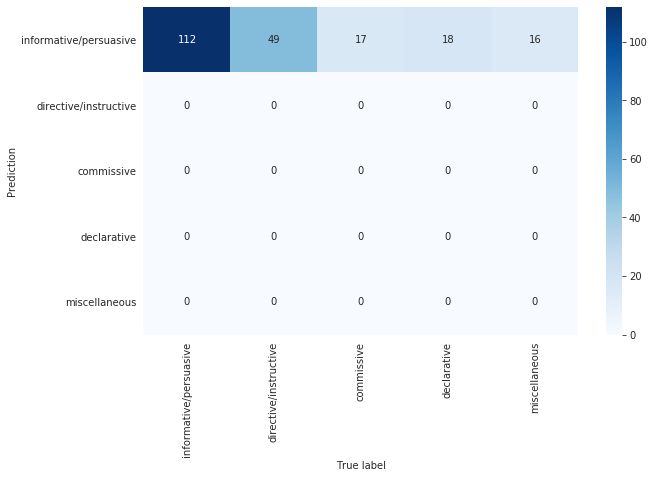

In [65]:
print(cm)

plt.figure(figsize = (10,7))
plot = sns.heatmap(cm, annot=True, xticklabels=x, yticklabels=y, cmap='Blues', fmt='d')
plot.set_xlabel("True label")
plot.set_ylabel("Prediction")
plot
plt.tight_layout(pad=2)
plot.figure.savefig('pics/BERTje_val.png')

In [61]:
pred_test = predict_BERTje(test_data['cleaned_text'])

In [62]:
print(classification_report(gold_labels_test, pred_test))


labels=['informative/persuasive','directive/instructive', 'commissive', 'declarative', 'miscellaneous']
x = labels
y = labels

cm = confusion_matrix(pred_test, gold_labels_test, normalize=None, labels=labels)

                        precision    recall  f1-score   support

            commissive       0.00      0.00      0.00        17
           declarative       0.00      0.00      0.00        18
 directive/instructive       0.00      0.00      0.00        49
informative/persuasive       0.53      1.00      0.69       112
         miscellaneous       0.00      0.00      0.00        16

              accuracy                           0.53       212
             macro avg       0.11      0.20      0.14       212
          weighted avg       0.28      0.53      0.37       212



/home/ADS/rinkl00_w00215/stageLR/lib64/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/ADS/rinkl00_w00215/stageLR/lib64/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/ADS/rinkl00_w00215/stageLR/lib64/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



[[112  49  17  18  16]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]]


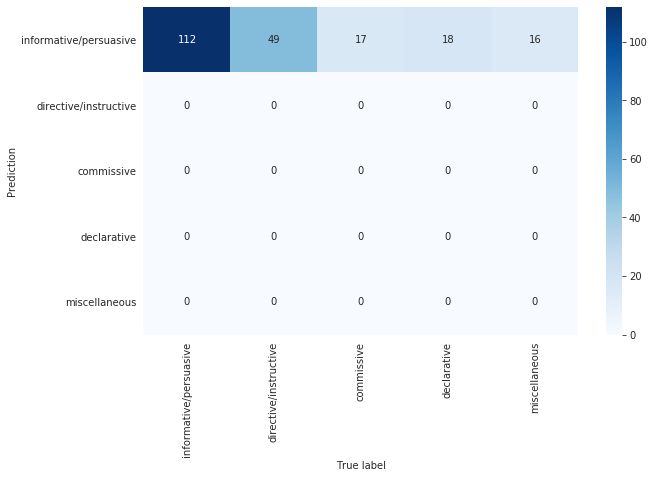

In [64]:
print(cm)

plt.figure(figsize = (10,7))
plot = sns.heatmap(cm, annot=True, xticklabels=x, yticklabels=y, cmap='Blues', fmt='d')
plot.set_xlabel("True label")
plot.set_ylabel("Prediction")
plot
plt.tight_layout(pad=2)
plot.figure.savefig('pics/BERTje_test.png')

### Performance per domain

In [51]:
def cm_subset(df, true, pred, label, column):
    df["pred"] = pred
    df = df[df[column] == label]
    true = df["SA Label"].tolist()
    pred = df["pred"].tolist()
    cm = confusion_matrix(true, pred, normalize=None)
    
    labels=['informative/persuasive','directive/instructive', 'commisive', 'miscellaneous'] ##add declarative later
    x = labels
    y = labels

    plt.figure(figsize = (10,7))
    plot = sns.heatmap(cm, annot=True, xticklabels=x, yticklabels=y, cmap='Blues')
    plot.set_xlabel("True label")
    plot.set_ylabel("Prediction")
    plot
    